# Классификация вин на двух признаках

In [1]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

# * seed для gpu отдельный:
torch.cuda.manual_seed(0)
# * детерминированный режим для библиотеки cudnn (более медленный, чем недетерменированный):
torch.backends.cudnn.deterministic = True

In [2]:
import sklearn.datasets
wine = sklearn.datasets.load_wine()
wine.data.shape

(178, 13)

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    # * берем только первые две колонки для удобства визуализации
    wine.data[:, :2],
    wine.target,
    test_size=0.3,
    shuffle=True
)

In [4]:
len(wine.feature_names)

13

In [5]:
wine.data.shape

(178, 13)

In [6]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)

y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [7]:
class WineNet(torch.nn.Module):
    def __init__(
        self,
        n_hidden_neurons
    ):

        super().__init__()

        self.fc1 = torch.nn.Linear(2, n_hidden_neurons)
        self.act1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.act2 = torch.nn.Sigmoid()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 3)
        self.sm = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)

        # ! возвращаем без преобразования к вероятностям,
        # ! т.к. они и не нужны для кросс-энтропии
        # ! (ожидается, что в нее подаются сырые логиты)
        return x

    def inference(self, x):
        x = self.forward(x)
        x = self.sm(x)
        return x

In [8]:
wine_net = WineNet(5)

In [9]:
loss = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    params=wine_net.parameters(),
    lr=1e-3
)

In [10]:
np.random.permutation(5)

array([2, 0, 1, 4, 3])

In [11]:
BATCH_SIZE = 10
EPOCH_SIZE = 5000

for epoch in range(EPOCH_SIZE):
    order = np.random.permutation(len(X_train))

    for start_index in range(0, len(X_train), BATCH_SIZE):

        optimizer.zero_grad()

        batch_indexes = order[start_index : start_index+BATCH_SIZE]

        x_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]

        preds = wine_net(x_batch)

        loss_val = loss(preds, y_batch)
        loss_val.backward()

        optimizer.step()

    if epoch % 100 == 0:
        test_preds = wine_net(X_test)
        test_preds = test_preds.argmax(dim=1)
        accuracy_test = (test_preds == y_test).float().mean().item()
        print(f"{epoch=} {accuracy_test=}")

epoch=0 accuracy_test=0.40740740299224854
epoch=100 accuracy_test=0.40740740299224854
epoch=200 accuracy_test=0.46296295523643494
epoch=300 accuracy_test=0.5
epoch=400 accuracy_test=0.42592594027519226
epoch=500 accuracy_test=0.40740740299224854
epoch=600 accuracy_test=0.5185185074806213
epoch=700 accuracy_test=0.5185185074806213
epoch=800 accuracy_test=0.4444444477558136
epoch=900 accuracy_test=0.42592594027519226
epoch=1000 accuracy_test=0.5
epoch=1100 accuracy_test=0.5370370149612427
epoch=1200 accuracy_test=0.5370370149612427
epoch=1300 accuracy_test=0.5370370149612427
epoch=1400 accuracy_test=0.7407407164573669
epoch=1500 accuracy_test=0.6851851940155029
epoch=1600 accuracy_test=0.6481481194496155
epoch=1700 accuracy_test=0.6851851940155029
epoch=1800 accuracy_test=0.6666666865348816
epoch=1900 accuracy_test=0.6851851940155029
epoch=2000 accuracy_test=0.6851851940155029
epoch=2100 accuracy_test=0.6851851940155029
epoch=2200 accuracy_test=0.7222222089767456
epoch=2300 accuracy_test

In [12]:
import matplotlib.pyplot as plt

/home/kerkuri/Code_proje/samsung_cv/samsung_cv_env/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/tmp/ipykernel_16478/913770647.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  X_train[indexes, 0],
/tmp/ipykernel_16478/913770647.py:24: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


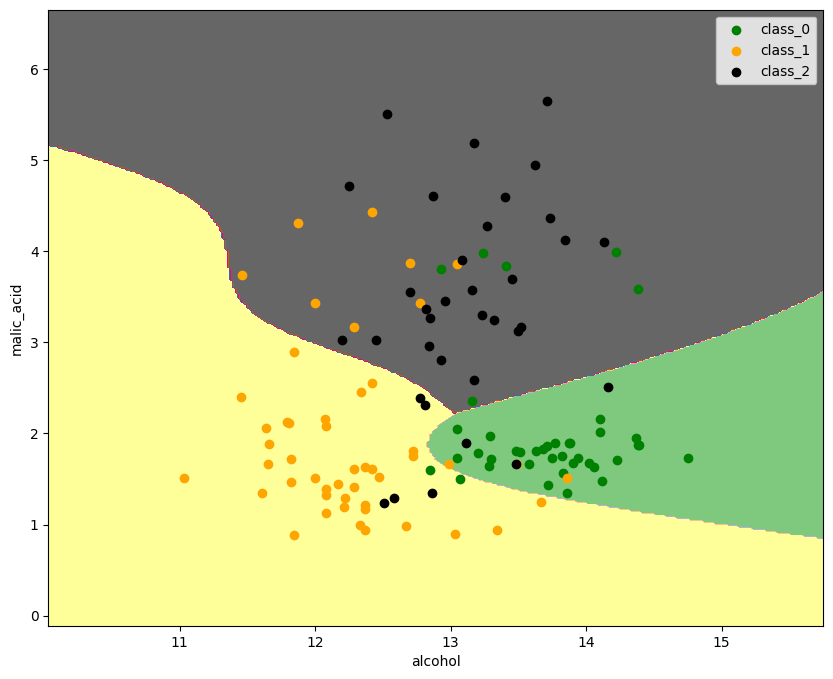

In [13]:
n_classes = 3
plot_colors = ['g', 'orange', 'black']
plot_step = 0.02

x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1

xx, yy =  torch.meshgrid(
    torch.arange(x_min, x_max, plot_step),
    torch.arange(y_min, y_max, plot_step)
)

preds = wine_net.inference(
    torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], dim=1))

preds_class = preds.data.numpy().argmax(axis=1)
preds_class = preds_class.reshape(xx.shape)

plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, preds_class, cmap='Accent')

for i, color in zip(range(n_classes), plot_colors):
    indexes = np.where(y_train == i)
    plt.scatter(
        X_train[indexes, 0], 
        X_train[indexes, 1], 
        c=color, 
        label=wine.target_names[i],
        cmap='Accent'
    )
    plt.xlabel(wine.feature_names[0])
    plt.ylabel(wine.feature_names[1])
    plt.legend()

## Смотрю, как меняется кросс-энтропия в зависимости от того, что в нее подается - логиты или вероятности

In [13]:
logits = torch.Tensor([1.2, -5, 3.4, 1])
logits

tensor([ 1.2000, -5.0000,  3.4000,  1.0000])

In [14]:
p = torch.nn.Softmax(dim=0)(logits)
p

tensor([9.2202e-02, 1.8712e-04, 8.3212e-01, 7.5488e-02])

In [28]:
targets = torch.FloatTensor([1, 0, 0, 1])
targets

tensor([1., 0., 0., 1.])

In [26]:
loss = torch.nn.CrossEntropyLoss()

In [31]:
from torch.nn.functional import cross_entropy

In [32]:
loss(logits, targets), cross_entropy(logits, targets)

(tensor(4.9676), tensor(4.9676))

In [34]:
loss(p, targets), cross_entropy(p, targets)

(tensor(3.2321), tensor(3.2321))

# Добавим больше признаков

Давайте попрактикуемся с WineNet. Измените архитектуру так, чтобы на вход принимались все 13 признаков и проведите следующие эксперименты:

1. Поэкспериментируйте с количеством нейронов в скрытых слоях. Попробуйте поставить очень маленькое число. Существует ли пороговое значение количества скрытых нейронов, при котором обучение становится невозможным?

2. Попробуйте передавать различные значения test_size в функцию train_test_split. При каком значении test_size сеть предсказывает хуже чем Base Rate*? И какой Base Rate у датасета вин?

3. Зависит ли время обучения на одной эпохе от размера батча? Исследуйте эту зависимость.

## 1. Поэкспериментируйте с количеством нейронов в скрытых слоях. Попробуйте поставить очень маленькое число. Существует ли пороговое значение количества скрытых нейронов, при котором обучение становится невозможным?

### Архитектура с одним скрытым слоем

In [1]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

# * seed для gpu отдельный:
torch.cuda.manual_seed(0)
# * детерминированный режим для библиотеки cudnn (более медленный, чем недетерменированный):
torch.backends.cudnn.deterministic = True

In [2]:
import sklearn.datasets
wine = sklearn.datasets.load_wine()
wine.data.shape

(178, 13)

In [3]:
N_FEATS = 13

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    wine.data[:, :N_FEATS],
    wine.target,
    test_size=0.3,
    shuffle=True
)

In [4]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)

y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [5]:
class WineNet(torch.nn.Module):
    def __init__(
        self,
        n_hidden_neurons
    ):

        super().__init__()

        self.fc1 = torch.nn.Linear(N_FEATS, n_hidden_neurons)
        self.act1 = torch.nn.Sigmoid()
        # self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        # self.act2 = torch.nn.Sigmoid()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 3)
        self.sm = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        # x = self.fc2(x)
        # x = self.act2(x)
        x = self.fc3(x)

        # ! возвращаем без преобразования к вероятностям,
        # ! т.к. они и не нужны для кросс-энтропии
        # ! (ожидается, что в нее подаются сырые логиты)
        return x

    def inference(self, x):
        x = self.forward(x)
        x = self.sm(x)
        return x

In [6]:
LR = 1e-3
BATCH_SIZE = 10
EPOCH_SIZE = 3000


In [7]:
import logging
logging.basicConfig(
    level=logging.INFO
)

logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [19]:
def train_wine_net(
    net,
    X_train,
    y_train,
    X_test,
    y_test,
    batch_size=BATCH_SIZE,
    epoch_size=EPOCH_SIZE,
    lr=LR,
    early_stop=True,
    n_iter_stop=5
):
    loss = torch.nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(
        params=net.parameters(),
        lr=lr
    )


    accuracy_test_hist = []
    max_accuracy = 0
    cnt_iter_not_impr = 0

    for epoch in range(epoch_size):
        order = np.random.permutation(len(X_train))

        for start_index in range(0, len(X_train), batch_size):

            optimizer.zero_grad()

            batch_indexes = order[start_index : start_index+batch_size]

            x_batch = X_train[batch_indexes]
            y_batch = y_train[batch_indexes]

            preds = net(x_batch)

            loss_val = loss(preds, y_batch)
            loss_val.backward()

            optimizer.step()

        if epoch % 100 == 0:
            test_preds = net(X_test)
            test_preds = test_preds.argmax(dim=1)
            accuracy_test = (test_preds == y_test).float().mean().item()
            accuracy_test_hist.append(accuracy_test)

            logger.debug(f"{epoch=} {accuracy_test=}")

            if early_stop:
                if (
                    accuracy_test - max_accuracy
                ) >= 1e-2:
                    cnt_iter_not_impr = 0
                else:
                    cnt_iter_not_impr += 1
                    logger.debug(f"{cnt_iter_not_impr=}")

                if cnt_iter_not_impr == n_iter_stop:
                    logger.warning(
                        f"early stop after {n_iter_stop=} "
                        f"at {epoch=} : {max_accuracy=}"
                    )
                    break

            max_accuracy = max(max_accuracy, accuracy_test)

    max_accuracy = max(max_accuracy, accuracy_test)
    return max_accuracy

In [20]:
log_level = logging.DEBUG

logging.basicConfig(
    level=log_level
)

logger.setLevel(log_level)

In [21]:
N_ITER = 10
N_HIDDEN_MAX = 15

n_hidden_space = range(1, N_HIDDEN_MAX+1)
n_hidden_accuracy_dict = dict()

for n_hidden in n_hidden_space:
    logger.info(
        f"{'~'*20} {n_hidden=} {'~'*20}"
    )

    iter_acc = []
    for i in range(N_ITER):
        logger.info(f"iter {i}")
        # torch.manual_seed(i)
        wine_net = WineNet(n_hidden)

        acc = train_wine_net(
            wine_net,
            X_train,
            y_train,
            X_test,
            y_test
        )

        iter_acc.append(acc)

    n_hidden_accuracy_dict[n_hidden] = iter_acc

INFO:root:~~~~~~~~~~~~~~~~~~~~ n_hidden=1 ~~~~~~~~~~~~~~~~~~~~
INFO:root:iter 0
DEBUG:root:epoch=0 accuracy_test=0.40740740299224854
DEBUG:root:epoch=100 accuracy_test=0.40740740299224854
DEBUG:root:cnt_iter_not_impr=1
DEBUG:root:epoch=200 accuracy_test=0.40740740299224854
DEBUG:root:cnt_iter_not_impr=2
DEBUG:root:epoch=300 accuracy_test=0.40740740299224854
DEBUG:root:cnt_iter_not_impr=3
DEBUG:root:epoch=400 accuracy_test=0.40740740299224854
DEBUG:root:cnt_iter_not_impr=4
DEBUG:root:epoch=500 accuracy_test=0.40740740299224854
DEBUG:root:cnt_iter_not_impr=5
INFO:root:iter 1
DEBUG:root:epoch=0 accuracy_test=0.24074074625968933
DEBUG:root:epoch=100 accuracy_test=0.40740740299224854
DEBUG:root:epoch=200 accuracy_test=0.40740740299224854
DEBUG:root:cnt_iter_not_impr=1
DEBUG:root:epoch=300 accuracy_test=0.40740740299224854
DEBUG:root:cnt_iter_not_impr=2
DEBUG:root:epoch=400 accuracy_test=0.40740740299224854
DEBUG:root:cnt_iter_not_impr=3
DEBUG:root:epoch=500 accuracy_test=0.40740740299224854

In [22]:
n_hidden_accuracy_dict

{1: [0.40740740299224854,
  0.40740740299224854,
  0.40740740299224854,
  0.40740740299224854,
  0.40740740299224854,
  0.40740740299224854,
  0.40740740299224854,
  0.7037037014961243,
  0.7407407164573669,
  0.40740740299224854],
 2: [0.40740740299224854,
  0.7222222089767456,
  0.40740740299224854,
  0.40740740299224854,
  0.7037037014961243,
  0.40740740299224854,
  0.40740740299224854,
  0.7037037014961243,
  0.40740740299224854,
  0.40740740299224854],
 3: [0.40740740299224854,
  0.7222222089767456,
  0.40740740299224854,
  0.40740740299224854,
  0.40740740299224854,
  0.40740740299224854,
  0.7407407164573669,
  0.40740740299224854,
  0.7037037014961243,
  0.40740740299224854],
 4: [0.7037037014961243,
  0.7222222089767456,
  0.40740740299224854,
  0.40740740299224854,
  0.40740740299224854,
  0.40740740299224854,
  0.40740740299224854,
  0.40740740299224854,
  0.7222222089767456,
  0.40740740299224854],
 5: [0.7407407164573669,
  0.9629629850387573,
  0.7222222089767456,
  0.70

In [26]:
logging.basicConfig(
    level=logging.INFO
)

In [27]:
import matplotlib.pyplot as plt

In [28]:
import numpy as np

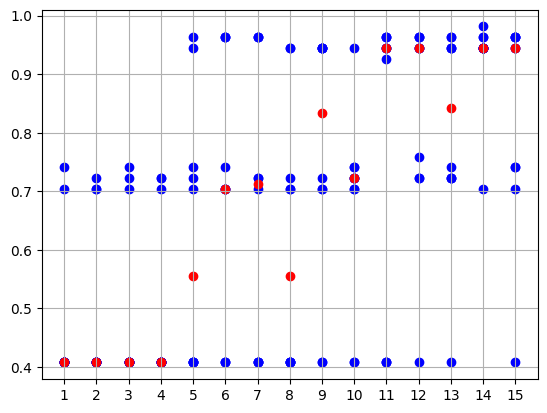

In [30]:
for i in n_hidden_space:
    plt.scatter(
        [i] * N_ITER,
        n_hidden_accuracy_dict[i],
        color='blue',
        label='accuracy'
    )

    plt.scatter(
        [i],
        np.median(n_hidden_accuracy_dict[i]),
        color='red',
        label='median accuracy'
    )

plt.xticks(n_hidden_space)
plt.grid()
plt.show()

> => При размере скрытого слоя >= 5 медиана accuracy становится больше Base Rate

## 2. Попробуйте передавать различные значения test_size в функцию train_test_split. При каком значении test_size сеть предсказывает хуже чем Base Rate*? И какой Base Rate у датасета вин?

In [1]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

# * seed для gpu отдельный:
torch.cuda.manual_seed(0)
# * детерминированный режим для библиотеки cudnn (более медленный, чем недетерменированный):
torch.backends.cudnn.deterministic = True

In [2]:
import sklearn.datasets
wine = sklearn.datasets.load_wine()
wine.data.shape

(178, 13)

In [3]:
from scipy.stats import mode

BASE_RATE = (mode(wine.target).mode == wine.target).mean()
BASE_RATE

0.398876404494382

In [4]:
N_FEATS = 13

In [5]:
class WineNet(torch.nn.Module):
    def __init__(
        self,
        n_hidden_neurons
    ):

        super().__init__()

        self.fc1 = torch.nn.Linear(N_FEATS, n_hidden_neurons)
        self.act1 = torch.nn.Sigmoid()
        # self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        # self.act2 = torch.nn.Sigmoid()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 3)
        self.sm = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        # x = self.fc2(x)
        # x = self.act2(x)
        x = self.fc3(x)

        # ! возвращаем без преобразования к вероятностям,
        # ! т.к. они и не нужны для кросс-энтропии
        # ! (ожидается, что в нее подаются сырые логиты)
        return x

    def inference(self, x):
        x = self.forward(x)
        x = self.sm(x)
        return x

In [6]:
LR = 1e-3
BATCH_SIZE = 10
EPOCH_SIZE = 3000


In [7]:
import logging
logging.basicConfig(
    level=logging.INFO
)

logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [11]:
from sklearn.model_selection import train_test_split

def train_wine_net_test_size(
    wine_data,
    test_size,
    random_state,
    batch_size=BATCH_SIZE,
    epoch_size=EPOCH_SIZE,
    lr=LR,
    early_stop=True,
    n_iter_stop=5
):
    X_train, X_test, y_train, y_test = train_test_split(
        wine_data.data[:, :N_FEATS],
        wine_data.target,
        test_size=test_size,
        stratify=wine_data.target,
        shuffle=True,
        random_state=random_state
    )

    X_train = torch.FloatTensor(X_train)
    X_test = torch.FloatTensor(X_test)
    y_train = torch.LongTensor(y_train)
    y_test = torch.LongTensor(y_test)

    net = WineNet(15)

    loss = torch.nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(
        params=net.parameters(),
        lr=lr
    )


    accuracy_test_hist = []
    max_accuracy = 0
    cnt_iter_not_impr = 0

    for epoch in range(epoch_size):
        order = np.random.permutation(len(X_train))

        for start_index in range(0, len(X_train), batch_size):

            optimizer.zero_grad()

            batch_indexes = order[start_index : start_index+batch_size]

            x_batch = X_train[batch_indexes]
            y_batch = y_train[batch_indexes]

            preds = net(x_batch)

            loss_val = loss(preds, y_batch)
            loss_val.backward()

            optimizer.step()

        if epoch % 100 == 0:
            test_preds = net(X_test)
            test_preds = test_preds.argmax(dim=1)
            accuracy_test = (test_preds == y_test).float().mean().item()
            accuracy_test_hist.append(accuracy_test)

            logger.debug(f"{epoch=} {accuracy_test=}")

            if early_stop:
                if (
                    accuracy_test - max_accuracy
                ) >= 1e-2:
                    cnt_iter_not_impr = 0
                else:
                    cnt_iter_not_impr += 1
                    logger.debug(f"{cnt_iter_not_impr=}")

                if cnt_iter_not_impr == n_iter_stop:
                    logger.warning(
                        f"early stop after {n_iter_stop=} "
                        f"at {epoch=} : {max_accuracy=}"
                    )
                    break

            max_accuracy = max(max_accuracy, accuracy_test)

    max_accuracy = max(max_accuracy, accuracy_test)
    return max_accuracy

In [42]:
log_level = logging.DEBUG

logging.basicConfig(
    level=log_level
)

logger.setLevel(log_level)

In [43]:
N_ITER = 10

test_size_space = np.arange(0.1, 1, 0.1)
test_size_dict = dict()

for test_size in test_size_space:
    logger.info(
        f"{'~'*20} {test_size=} {'~'*20}"
    )

    iter_acc = []
    for i in range(N_ITER):
        logger.info(f"iter {i}")

        acc = train_wine_net_test_size(
            wine_data=wine,
            test_size=test_size,
            random_state=i
        )

        iter_acc.append(acc)

    test_size_dict[test_size] = iter_acc

INFO:root:~~~~~~~~~~~~~~~~~~~~ test_size=0.1 ~~~~~~~~~~~~~~~~~~~~
INFO:root:iter 0
DEBUG:root:epoch=0 accuracy_test=0.3888888955116272
DEBUG:root:epoch=100 accuracy_test=1.0
DEBUG:root:epoch=200 accuracy_test=1.0
DEBUG:root:cnt_iter_not_impr=1
DEBUG:root:epoch=300 accuracy_test=1.0
DEBUG:root:cnt_iter_not_impr=2
DEBUG:root:epoch=400 accuracy_test=1.0
DEBUG:root:cnt_iter_not_impr=3
DEBUG:root:epoch=500 accuracy_test=1.0
DEBUG:root:cnt_iter_not_impr=4
DEBUG:root:epoch=600 accuracy_test=1.0
DEBUG:root:cnt_iter_not_impr=5
INFO:root:iter 1
DEBUG:root:epoch=0 accuracy_test=0.3333333432674408
DEBUG:root:epoch=100 accuracy_test=0.7222222089767456
DEBUG:root:epoch=200 accuracy_test=0.8888888955116272
DEBUG:root:epoch=300 accuracy_test=0.8888888955116272
DEBUG:root:cnt_iter_not_impr=1
DEBUG:root:epoch=400 accuracy_test=0.9444444179534912
DEBUG:root:epoch=500 accuracy_test=0.8888888955116272
DEBUG:root:cnt_iter_not_impr=1
DEBUG:root:epoch=600 accuracy_test=0.9444444179534912
DEBUG:root:cnt_iter_n

In [44]:
logging.basicConfig(
    level=logging.INFO
)

In [45]:
import matplotlib.pyplot as plt

In [46]:
import numpy as np

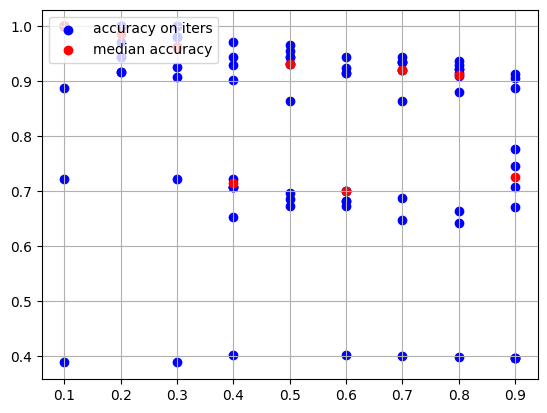

In [47]:
plt.scatter(
    np.concatenate([[k]*N_ITER for k in test_size_dict.keys()]),
    np.concatenate(list(test_size_dict.values())),
    color='blue',
    label='accuracy on iters'
)

plt.scatter(
    list(test_size_dict.keys()),
    list(map(lambda x: np.median(x), test_size_dict.values())),
    color='red',
    label='median accuracy'
)

plt.legend(loc='upper left')
plt.xticks(test_size_space)
plt.grid()
plt.show()

> => Явной зависимости от test_size не видно, т.к. выборка сама по себе довольно маленькая

## 3. Зависит ли время обучения на одной эпохе от размера батча? Исследуйте эту зависимость.

In [1]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

# * seed для gpu отдельный:
torch.cuda.manual_seed(0)
# * детерминированный режим для библиотеки cudnn (более медленный, чем недетерменированный):
torch.backends.cudnn.deterministic = True

In [2]:
import sklearn.datasets
wine = sklearn.datasets.load_wine()
wine.data.shape

(178, 13)

In [3]:
N_FEATS = 13

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    wine.data[:, :N_FEATS],
    wine.target,
    test_size=0.3,
    shuffle=True,
    stratify=wine.target
)

In [5]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [6]:
class WineNet(torch.nn.Module):
    def __init__(
        self,
        n_hidden_neurons
    ):

        super().__init__()

        self.fc1 = torch.nn.Linear(N_FEATS, n_hidden_neurons)
        self.act1 = torch.nn.Sigmoid()
        # self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        # self.act2 = torch.nn.Sigmoid()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 3)
        self.sm = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        # x = self.fc2(x)
        # x = self.act2(x)
        x = self.fc3(x)

        # ! возвращаем без преобразования к вероятностям,
        # ! т.к. они и не нужны для кросс-энтропии
        # ! (ожидается, что в нее подаются сырые логиты)
        return x

    def inference(self, x):
        x = self.forward(x)
        x = self.sm(x)
        return x

In [7]:
LR = 1e-3
BATCH_SIZE = 10
EPOCH_SIZE = 3000


In [12]:
import logging
logging.basicConfig(
    level=logging.INFO
)

logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [13]:
import time

def train_wine_net_batch_size_time(
    batch_size,
    X_train,
    y_train,
    X_test,
    y_test,
    epoch_size=EPOCH_SIZE,
    lr=LR,
    early_stop=True,
    n_iter_stop=5
):

    net = WineNet(15)

    loss = torch.nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(
        params=net.parameters(),
        lr=lr
    )

    accuracy_test_hist = []
    epoch_time_list = []
    max_accuracy = 0
    cnt_iter_not_impr = 0

    for epoch in range(epoch_size):
        start_time = time.time()

        order = np.random.permutation(len(X_train))

        for start_index in range(0, len(X_train), batch_size):

            optimizer.zero_grad()

            batch_indexes = order[start_index : start_index+batch_size]

            x_batch = X_train[batch_indexes]
            y_batch = y_train[batch_indexes]

            preds = net(x_batch)

            loss_val = loss(preds, y_batch)
            loss_val.backward()

            optimizer.step()

        end_time = time.time()
        delta_time = end_time - start_time
        epoch_time_list.append(delta_time)

        if epoch % 100 == 0:
            test_preds = net(X_test)
            test_preds = test_preds.argmax(dim=1)
            accuracy_test = (test_preds == y_test).float().mean().item()
            accuracy_test_hist.append(accuracy_test)

            logger.debug(f"{epoch=} {accuracy_test=}")
            logger.debug(f"{delta_time=}")

            if early_stop:
                if (
                    accuracy_test - max_accuracy
                ) >= 1e-2:
                    cnt_iter_not_impr = 0
                else:
                    cnt_iter_not_impr += 1
                    logger.debug(f"{cnt_iter_not_impr=}")

                if cnt_iter_not_impr == n_iter_stop:
                    logger.warning(
                        f"early stop after {n_iter_stop=} "
                        f"at {epoch=} : {max_accuracy=}"
                    )
                    break

            max_accuracy = max(max_accuracy, accuracy_test)

    return np.mean(epoch_time_list)

In [48]:
log_level = logging.DEBUG

logging.basicConfig(
    level=log_level
)

logger.setLevel(log_level)

In [49]:
N_ITER = 1

batch_size_space = list(range(10, len(X_train), 15))
batch_size_space.append(len(X_train))

batch_size_time_dict = dict()

for batch_size in batch_size_space:
    logger.info(
        f"{'~'*20} {batch_size=} {'~'*20}"
    )

    iter_time_list = []
    for i in range(N_ITER):
        logger.info(f"iter {i}")

        avg_time = train_wine_net_batch_size_time(
            batch_size=batch_size,
            X_train=X_train,
            X_test=X_test,
            y_train=y_train,
            y_test=y_test,
            early_stop=False,
            epoch_size=1000
        )
        iter_time_list.append(avg_time)

    batch_size_time_dict[batch_size] = iter_time_list

INFO:root:~~~~~~~~~~~~~~~~~~~~ batch_size=10 ~~~~~~~~~~~~~~~~~~~~
INFO:root:iter 0
DEBUG:root:epoch=0 accuracy_test=0.3333333432674408
DEBUG:root:delta_time=0.020377397537231445
DEBUG:root:epoch=100 accuracy_test=0.9074074029922485
DEBUG:root:delta_time=0.026779890060424805
DEBUG:root:epoch=200 accuracy_test=0.9444444179534912
DEBUG:root:delta_time=0.026636123657226562
DEBUG:root:epoch=300 accuracy_test=0.9444444179534912
DEBUG:root:delta_time=0.023528099060058594
DEBUG:root:epoch=400 accuracy_test=0.9444444179534912
DEBUG:root:delta_time=0.026926755905151367
DEBUG:root:epoch=500 accuracy_test=0.9629629850387573
DEBUG:root:delta_time=0.026736974716186523
DEBUG:root:epoch=600 accuracy_test=0.9629629850387573
DEBUG:root:delta_time=0.024693012237548828
DEBUG:root:epoch=700 accuracy_test=0.9629629850387573
DEBUG:root:delta_time=0.023096323013305664
DEBUG:root:epoch=800 accuracy_test=0.9444444179534912
DEBUG:root:delta_time=0.02262401580810547
DEBUG:root:epoch=900 accuracy_test=0.9629629850

In [50]:
batch_size_time_dict

{10: [0.02615974497795105],
 25: [0.010366081237792969],
 40: [0.007632176399230957],
 55: [0.005921871900558472],
 70: [0.004212228775024414],
 85: [0.004702577114105225],
 100: [0.004346029996871948],
 115: [0.004372373819351196],
 124: [0.0023581366539001465]}

In [51]:
logging.basicConfig(
    level=logging.INFO
)

In [52]:
import matplotlib.pyplot as plt

In [53]:
import numpy as np

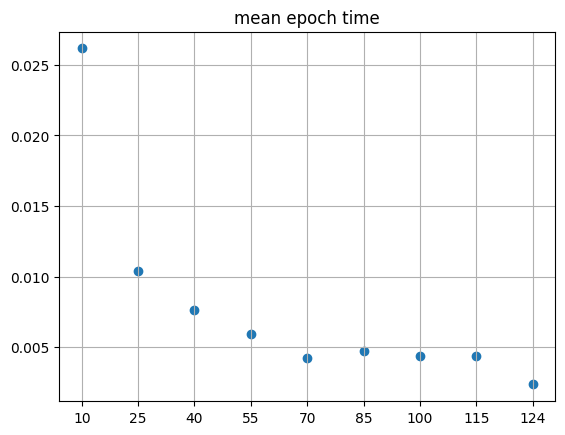

In [54]:
plt.scatter(
    range(len(batch_size_time_dict.keys())),
    list(batch_size_time_dict.values())
)

plt.title('mean epoch time')
plt.xticks(
    ticks=range(len(batch_size_space)),
    labels=batch_size_space
)
plt.grid()
plt.show()

> => Чем больше размер батча, тем быстрее эпоха в среднем.